<a href="https://colab.research.google.com/github/RayOfLight07/Deep-Learning/blob/main/DL_LAB_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep learning Lab_________________________________________________________________________Name: Deepasnhu Rathore     
B.Tech. 5th Sem.
#**Experiment:- 13**
# Synthetic Image Generation via Generative Adversarial Networks (GANs)

Date:18\11\2025____________________________________________________________________________________SAP: 500124406

# **AIM**
Aim: To develop and train a Generative Adversarial Network (GAN) using TensorFlow/Keras to generate realistic handwritten digits.

# **Objective**

*   To implement the Adversarial Training loop where a Generator competes against a Discriminator.

*   To observe how the Generator learns to create realistic images from random noise over time.

*   To compare the sharpness (fidelity) of GAN images against VAE images.

A GAN consists of two networks training simultaneously:

*   **Generator ($G$)**: Takes random noise as input and tries to generate an image that looks real. It is trained to fool the discriminator.

*   **Discriminator ($D$)**: Takes an image (real or fake) as input and tries to classify it as "Real" or "Fake".

The training is a zero-sum game: The Generator improves by maximizing the Discriminator's error, while the Discriminator improves by minimizing it.

# **Import Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import time

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


# **Load and Preprocess Data**

Important: We normalize images to [-1, 1] (not [0, 1]) because the Generator's final layer uses tanh activation, which outputs values between -1 and 1.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Reshape to (Batch, 28, 28, 1) and normalize to [-1, 1]
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print("Data loaded and normalized to [-1, 1]")

Data loaded and normalized to [-1, 1]


# **Define the Generator**

This network takes a random noise vector (seed) and upsamples it into a 28x28 image.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    # Start with a dense layer taking a 100D noise vector
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    # Upsample to 14x14
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 14x14 (strides handle the upsampling logic here differently in some architectures,
    # but here we use strides=2 in the next layer to go to 28x28)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Output Layer: Upsample to 28x28.
    # Activation is 'tanh' to match the [-1, 1] data range.
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = make_generator_model()
print("Generator built.")


Generator built.


# **Define the Discriminator**

This is a standard CNN classifier that outputs a single value: positive numbers for "real", negative for "fake".

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    # Downsample
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and output a single score
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
print("Discriminator built.")

Discriminator built.


# **Define Loss and Optimizers**

We use Binary Crossentropy but with from_logits=True.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator Loss: Real images should be 1, Fake images should be 0
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Generator Loss: Fake images should be 1 (to fool discriminator)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers (Adam is standard for GANs)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


# **Define the Training Loop (The "Adversarial" Step)**

This uses tf.function to compile the training step for high performance.

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We reuse this seed to visualize progress on the SAME digits over time
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # 1. Generator creates fake images
      generated_images = generator(noise, training=True)

      # 2. Discriminator evaluates real and fake images
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      # 3. Calculate losses
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 4. Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 5. Apply gradients (Backprop)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# **Run Training**

This will take about 10-15 minutes on Colab GPU. It prints the time per epoch and shows generated images every 10 epochs.

Starting GAN Training...


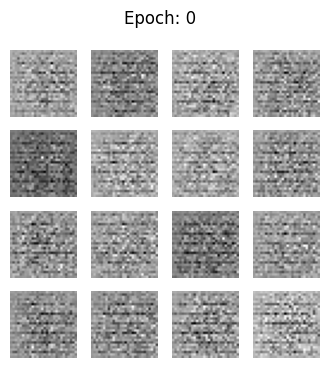

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # Rescale from [-1, 1] to [0, 1] for plotting
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.suptitle(f"Epoch: {epoch}")
  plt.show()

print("Starting GAN Training...")
generate_and_save_images(generator, 0, seed) # Show noise before training

for epoch in range(EPOCHS):
  start = time.time()

  for image_batch in train_dataset:
    train_step(image_batch)

  # Save the model every 15 epochs
  if (epoch + 1) % 10 == 0:
    generate_and_save_images(generator, epoch + 1, seed)
    print (f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')

print("Training Complete.")

# **Observations**

*   **Epoch 0:** The output is pure TV static (noise).

*   **Epoch 10-20:** Shapes begin to form, looking like blobby digits.

*   **Epoch 50:** The generator produces clear, distinct digits.

**Comparison with VAE:**

*   **Sharpness:** The GAN images are noticeably sharper and have higher contrast than VAE images (which often look slightly blurry).

*   **Diversity:** GANs can sometimes suffer from "Mode Collapse" (generating the same '1' over and over), whereas VAEs usually cover the diversity of digits better.

# **Conclusion**


*   The adversarial training successfully forced the Generator to learn the data distribution. The experiment confirms that GANs are superior for generating high-fidelity (realistic) images compared to standard VAEs
